In [2]:
from diffusers import StableDiffusionXLControlNetInpaintPipeline, ControlNetModel, DDIMScheduler
from diffusers import StableDiffusionXLPipeline,DPMSolverMultistepScheduler
import torch
import matplotlib.pyplot as plt
from diffusers.schedulers import AysSchedules
import gc
from diffusers.utils import load_image
from PIL import Image
import cv2
import numpy as np


pipeline = StableDiffusionXLPipeline.from_pretrained(
            "/home/nas/buffer/mohan.dash/ghibli-illustrious-v10-sdxl",torch_dtype=torch.float16
        )

pipeline = pipeline.to("cuda",dtype=torch.float16)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

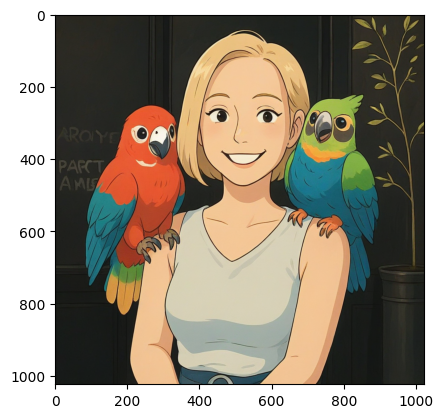

In [6]:
prompt = 'woman smile, parrot on her shoulder'
prompt2 = "woman smile, parrot on her shoulder"
neg_prompt = "blurry, low res, low quality"

images = pipeline(
                  prompt=prompt,
                  prompt2=prompt2,
                  negative_prompt=neg_prompt,
                  num_inference_steps=20,
                  ).images[0]

plt.imshow(images)
plt.show()

# Image to image diffusion

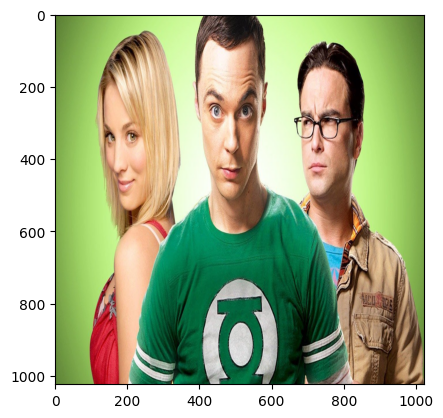

In [10]:
from diffusers import StableDiffusionXLImg2ImgPipeline
pipe_im2im = StableDiffusionXLImg2ImgPipeline.from_pipe(pipeline)
input_image = load_image("gibli_photos/bbt.png").resize((1024, 1024))
input_image = input_image.convert("RGB")
plt.imshow(input_image)

  0%|          | 0/10 [00:00<?, ?it/s]

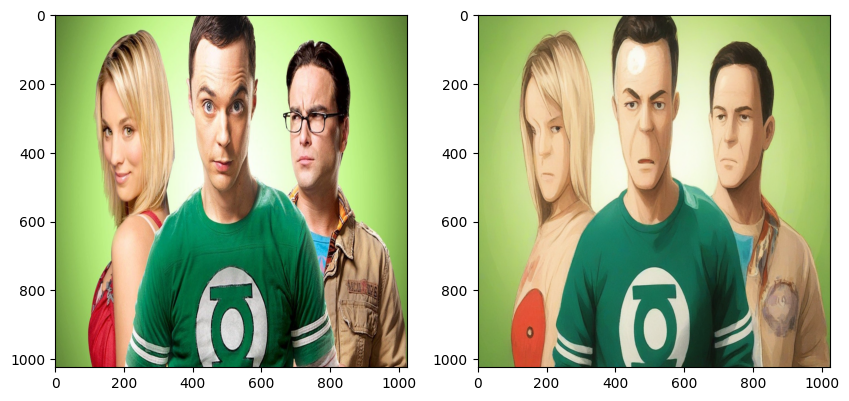

In [13]:
prompt = ''
prompt2 = prompt
neg_prompt = "blurry, low res, low quality"

images = pipe_im2im(
            prompt=prompt,
            prompt2=prompt2,
            negative_prompt=neg_prompt,
            image=input_image,
            strength=0.5,
            num_inference_steps=20,
        ).images[0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.subplot(1, 2, 2)
plt.imshow(images)
plt.show()

# Image2image with Controlnet

In [5]:
from diffusers import StableDiffusionXLControlNetImg2ImgPipeline


controlnet_canny = ControlNetModel.from_pretrained("/home/nas/buffer/mohan.dash/sdxl_canny_controlnet", torch_dtype=torch.float16)
controlnet_canny = controlnet_canny.to("cuda",dtype=torch.float16)

controlnet_depth = ControlNetModel.from_pretrained("/home/nas/buffer/mohan.dash/controlnet-depth-sdxl", torch_dtype=torch.float16)
controlnet_depth = controlnet_depth.to("cuda",dtype=torch.float16)


pipe_controlnet = StableDiffusionXLControlNetImg2ImgPipeline.from_pipe(pipeline,controlnet=[controlnet_canny,controlnet_depth], torch_dtype=torch.float16)


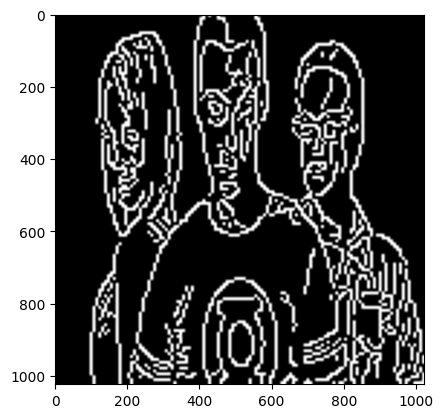

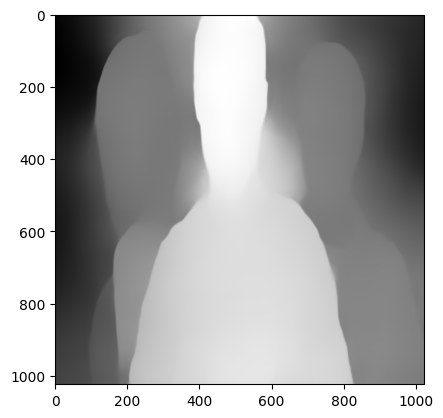

In [27]:
from transformers import DPTFeatureExtractor, DPTForDepthEstimation

depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to("cuda")
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")



def make_canny_condition(image):
    org_shape = image.size
    image = np.array(image.resize((128,128)))
    image = cv2.Canny(image, 100, 200)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    image = Image.fromarray(image)
    return image.resize(org_shape)

def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to("cuda")
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)

    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image

control_image_canny = make_canny_condition(input_image)
plt.imshow(control_image_canny)
plt.show()

control_image_depth = get_depth_map(input_image)
plt.imshow(control_image_depth)
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

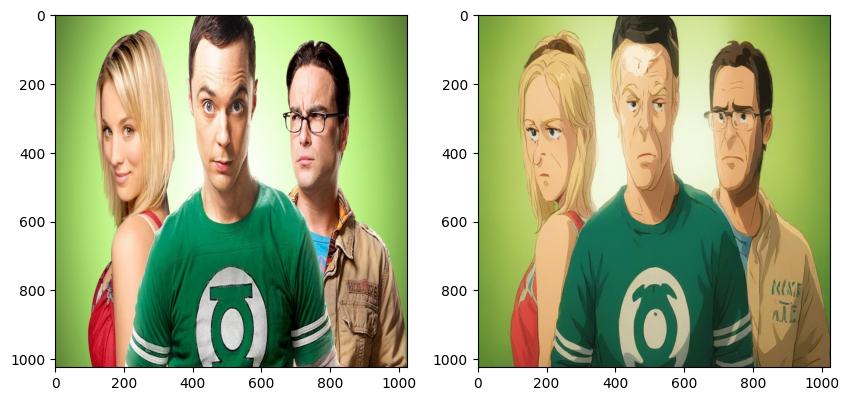

: 

In [ ]:
prompt = 'one women on the left blonde hair, one men at the center, one men with glasses on the right'
prompt2 = prompt
neg_prompt = "blurry, low res, low quality"

image = pipe_controlnet(
    prompt=prompt,
    # prompt2=prompt2,
    # negative_prompt=neg_prompt,
    num_inference_steps=20,
    strength=0.5,
    eta=1.0,
    image=input_image,
    control_image=[control_image_canny, control_image_depth],
    controlnet_conditioning_scale=[0, 1],
    guidance_scale=5,
).images[0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.show()